# Strategic Teams

After experimenting with a policy-gradient based leader agent in [Crossing_Leader_PG.ipynb](Crossing_Leader_PG.ipynb), we arrived at the conclusion that RL (policy-gradient or Q-learning) are not effective at strategic decision making. Specifically, the leader agent with complete observation of the game space is not able to overcome the problems of local optima and sparce reward.

It is therefore necessary to seperate the behavioral aspect of a team from its strategic decision making.

## Strategist Class

A strategist analyzes the strategic position of the teams of agents it is responsible for directing, based on observable game space and game metrics provided by the Environment. Implemented as a black box, it outputs a Task/Objective for each team.

## Team Class

The Team class has a Mission and a Culture.

A team's Culture is used to shape an agent's behavior regardless of role or type. It does so by adding an "imaginary" behavioral reward/penalty to the reward given to the agent by the environment during training. Doing so shape the agent's policy NN so that it conforms to the cultural behaviors expected by the team.

A team's Mission/Goal converts the strategist's Task/Objective into a "imaginary" mission reward. This mission reward is added to the reward given to an agent by the environment and the team's Culture during training. Doing so shape the agent's policy NN so that it achieves the task/objective demanded of the team. 

A team doles out behavioral and mission reward to its agents regardless of type or role so that it can accomplish the task/objective set by its strategist.

## Strategist directing multiple Teams

We envision a multi-agent organization whereby:

* A Strategist directs multiple Teams through Tasks/Objectives.

* Each Team is made up of agents of different types (drones and crawlers) and roles (leaders and followers).

* A Team uses its Culture to shape its agents' behaviors by doling out behavorial rewards during training. It uses its Mission to help its agents learn abilities to accomplish individual or group objectives by doling out mission rewards during training.

* In this way, a Strategist that is optimized for strategic decision making can analyze the games space and direct multiple Teams to accomplish more complex and strategic tasks that require more than behavioral skills.

In [33]:
import os
import random
import time
import platform
import torch
import torch.optim as optim
import gym
import numpy as np
import pickle

# This is the Crossing game environment
from xteams_env import CrossingEnv
from xteams_model import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Strategist Class

(Wikipedia) A strategist is responsible for the formulation and implementation of a strategy. Strategy generally involves setting goals, determining actions to achieve the goals, and mobilizing resources to execute the actions. It describes how the ends (goals) will be achieved by the means (resources).

An agent belonging to the Strategist class performs the following:

(1) It accepts and abdicates responsibilities for directing teams of agents

(2) It receives game space and metrics from the Environment

(3) It analyzes the game space and metrics to arrive at a "strategic position" for its teams. e.g. a topological map and/or a set of game stats

(4) Based on the strategic position, it decides on a set of goals that need to be accomplished

(5) It surveys its teams of agents and their location in the games space

(6) For each goal, it picks the best team and assign it the goal

(7) If necessary, it reorganize the teams and the agents

(8) It measures the effectiveness of the teams in accomplishing the assigned goals, and whether the "strategic position" has improved for its teams


In [2]:
import os
import random
import time
import platform
import torch
import gym
import numpy as np
from collections import deque
from torch.autograd import Variable

class Strategist():
    
    teams = []
    eyes = []  # Each team has a drone agent that serves as an eye for the strategist
    game_spaces = []
    game_metrics = []

    
    def __init__(self):
        super(Strategist, self).__init__()
        
        # Teams parameters
        self.teams = []
        self.eyes = []
        
        # Teams' game spaces  
        self.game_spaces = []
        
        # Teams' game metrics
        self.game_metrics = []
        
        
        # zone parameters

        # episode history

        return
    
    # This method accepts directorship of a team of agents, but only if the team has a drone agent
    # that can act as eye for the strategist.
    def accept(self, team):
        
        eye_found = False
        
        # Look for drone agent in team
        for agent in team.members:
            if agent.type is "drone":
                self.eyes.append(agent)  # assign agent as team eye
                eye_found = True
                break
        
        # Only accept directorship of a team if there is a team eye
        if eye_found:
            self.teams.append(team)  
        else:
            raise Exception('Cannot accept team directorship! Team {} has no drone.'.format(team.name))
            
        return
    
    # This method abdicates directorship of a team of agents
    def abdicate(self, team):
        try:
            self.teams.remove(team)
        except ValueError:
            print("Cannot abdicate team directorship! Team {} is not under strategist's direction.".format(team.name))
        return

    
    # This method generates a favorability topological map from the game space 
    def _topology(self, game_space):
        
        space = game_space.numpy()
        _,_,x,y = space.shape
        
        topology = np.zeros((x,y))
        
        # Generate favorability topology based on food units in 5x5 target zone
        for ix,iy in np.ndindex(x,y):
            topology[ix,iy] = np.sum(space[0,0,ix:ix+5, iy:iy+5])

        return topology


    # This "black box" method generates a set of goals after analyzing the game space and metrics
    def generate_goals(self, game_space):
        
        # Create a topology of favorability
        topology = self._topology(game_space)
        
        # Find the coordinate of highest favorability
        i,j = np.unravel_index(topology.argmax(), topology.shape)
        
        goals = [(i,j)]  # The goal is to move a team to the coordinate of highest favorability
        
        return goals, topology
    
        
    def _assign_goal(self, goal, team):
        
        # TBD
        
        return  
    
    # This method flush the strategist's history at the end of a game episode    
    def clear_history(self):
        
        return

    # This method resets strategist by abdicating all team directorships
    def reset(self):
        # Abdicate directorship for all teams
        self.teams = []
        self.eyes = []
        self.game_spaces = []
        self.game_metrics = []
        
        return


# Play Game with Strategist

For now, the strategist can only direct 1 team with a drone agent. It access the game space through the complete obs space of the drone agent.


In [31]:
folders = [
    # Agents trained in map = food_d37
    'models/1T-10L/baseline/food_d37/pacifist/t0.4_rp-1.0_300gs/',   # scenario=1
    'models/1T-10L/baseline/food_d37/pacifist/t0.8_rp-1.0_300gs/',   # scenario=2
    'models/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_300gs/',   # scenario=3
    'models/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_600gs/',   # scenario=4
    'models/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_300gs/',   # scenario=5
    'models/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_600gs/',   # scenario=6
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_300gs/',   # scenario=7
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_600gs/',   # scenario=8
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_1200gs/',   # scenario=9
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_300gs/',   # scenario=10
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_600gs/',   # scenario=11
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_1200gs/',   # scenario=12
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_300gs/',   # scenario=13
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_600gs/',   # scenario=14
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_1200gs/',   # scenario=15
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_300gs/',   # scenario=16
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_600gs/',   # scenario=17
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_1200gs/',   # scenario=18

    # Agents trained in map = food_d37_river_w1_d25
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.0_rp-1.0_300gs/",   # scenario=19
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.25_rp-1.0_300gs/",   # scenario=20 
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t2.0_rp-1.0_300gs/",   # scenario=21
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t4.0_rp-1.0_300gs/",   # scenario=22
    
    # 2 Teams of 5 Agents trained in map = food_d37
    "models/2T-5L/baseline/food_d37/pacifist/t1.25_rp-1.0_300gs/",     # scenario=23
    "models/2T-5L/baseline/food_d37/pac_vs_coop/t1.25_rp-1.0_300gs/",   # scenario=24
    
    # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
    # Team Viking (Pacifist w/o leader) vs Team Frank (Cooperative)
    "models/2T-5L/baseline/food_d37_river_w1_d25/pac_vs_coop/t1.25_rp-1.0_300gs/",   # scenario=25
    
    # Team Viking (Pacifist w/ leader) vs Team Frank (No Leader)
    "models/2T-5L/pac_leader/food_d37_river_w1_d25/pac_vs_coop/t1.25_rp-1.0_300gs/", # scenario=26
    "models/2T-5L/pac_leader/food_d37_river_w1_d25/pac_vs_coop/t2.0_rp-1.0_300gs/",   # scenario=27
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_coop/t1.5_rp-1.0_300gs/",   # scenario=28
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t1.5_rp-1.0_300gs/",   # scenario=29 
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t2.0_rp-1.0_300gs/",   # scenario=30  
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples/t2.0_rp-1.0_300gs/",   # scenario=31
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples_teamreward/t2.0_rp-1.0_300gs/",    # scenario=32
    "models/1T-1L/strategist/food_d37_river_w1_d25/pac_simple_droneleader/t2.0_rp-1.0_300gs/",   # scenario=33
    "models/1T-11L/strategist/food_d37_river_w1_d25/pac_simple_droneleader_followers/t2.1_rp-1.0_300gs/",   # scenario=34
]

# Parameter sets pertaining to the trained models in the folders above (not used in the code)
parameters =[ 
        # Temperature for explore/exploit; penalty per step in river; game steps per episode
    
        # 1 Team of 10 Agents trained in map = food_d37
            {'temp_start':0.4, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':0.8, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':1200},
    
        # 1 Team of 10 Agents trained in map = food_d37_river_w1_d25    
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
        # Team Viking (Pacifist w/ leader) vs Team Frank (Cooperative)
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},    
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},   
            {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':1.0, 'game_steps':300},     
            {'temp_start':2.1, 'river_penalty':-1.0, 'target_reward':1.0, 'game_steps':300}, 
            ]

print (len(parameters))
print (len(folders))

34
34


In [44]:
from torch.autograd import Variable

game = 'Crossing'
# map_name = "food_d37_river_w1_d25_v2"
map_name = "food_d37_river_w1_d25"
# map_name "food_d37"

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 34
dir_name = folders[scenario-1]
parameter = parameters[scenario-1]
episodes = 1000  # This is used to recall a model file trained to a # of episodes

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-33
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
]

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)}
]


def calc_deltas(goal, current):
    # Calculate delta between the current and the target coordinates
    target_x, target_y = goal
    current_x, current_y = current
    delta_x = (target_x - current_x)/60   # normalize
    delta_y = (target_y - current_y)/20    # normalize
    deltas = torch.Tensor([delta_x,delta_y])
    deltas = deltas.view(1, -1)
        
    # print(deltas)
    return deltas   

# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 200

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA{}_{}_ep{}.p'.format(i,game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    print("Load Drone Leader.")
                    agent = DroneLeader_Advanced(num_frames, num_goal_params, num_drone_actions, i)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:5]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_agent=0)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                actions[i], _ = select_action_strat(agents[i], agents_obs[i], deltas, cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')
print ('Total rewards gathered = {}'.format(total_rewards))
print ('Av. rewards per agent = {0:.2f}'.format(total_rewards/num_ai_agents))
print ('Num laser fired = {}'.format(total_tags))
print ('Total US Hit (friendly fire) = {}'.format(total_US_hits))
print ('Total THEM Hit = {}'.format(total_THEM_hits))
print ('friendly fire (%) = {0:.3f}'.format(total_US_hits/(total_US_hits+total_THEM_hits+1e-7)))

for (i, loc) in env.consumption:
    if loc[0] > second_pile_x:
        # print ('agent {} gathered an apple in 2nd pile'.format(i))
        crossed[i] = 1
        
print ("Num agents gathering from 2nd food pile: {}".format(sum(crossed)))

print ('\nStatistics by Team')
print ('===================')
top_team = None
top_team_reward = 0

for i, team in enumerate(teams):
    if team.name is not 'Crazies':
        reward = sum(team.sum_rewards())
        print ('Team {} has total reward of {}'.format(team.name, reward))
                           
        if reward > top_team_reward:   # Keep track of dominating team
            top_team_reward = reward
            top_team = team.name

# Team dominance calculation
if len(teams) > 1:
    print ('Dominating Team: {}'.format(top_team))
    dominance = top_team_reward/((total_rewards-top_team_reward+1.1e-7)/(len(teams)-1))    
    print ('Team dominance: {0:.2f}x'.format(dominance))


Load saved model for agent 0
Load Drone Leader.

Statistics by Agent
Agent0 reward is 0

Statistics in Aggregate
Total rewards gathered = 0
Av. rewards per agent = 0.00
Num laser fired = 0
Total US Hit (friendly fire) = 0
Total THEM Hit = 0
friendly fire (%) = 0.000
Num agents gathering from 2nd food pile: 0

Statistics by Team
Team Vikings has total reward of 0


In [39]:
deltas

tensor([[72.6833, 22.6000]])

SunTzu is strategist for Team Vikings.
Agent 0 (drone leader) is acting as eye for SunTzu.
Display the Big Picture!
torch.Size([1, 7, 100, 60])


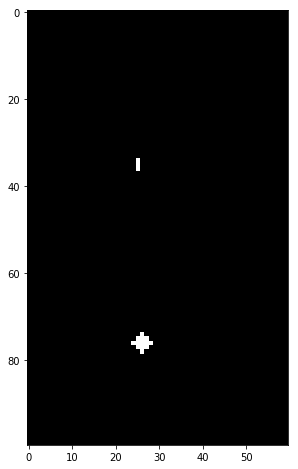

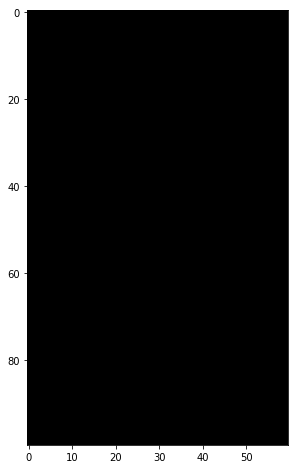

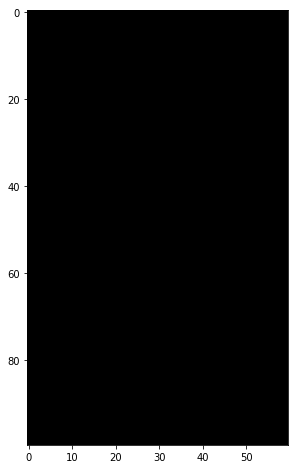

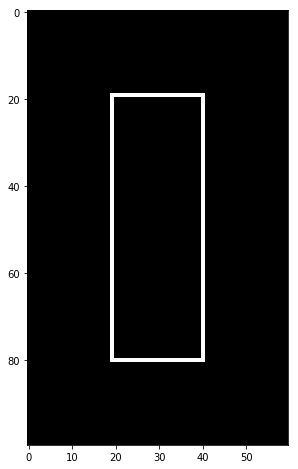

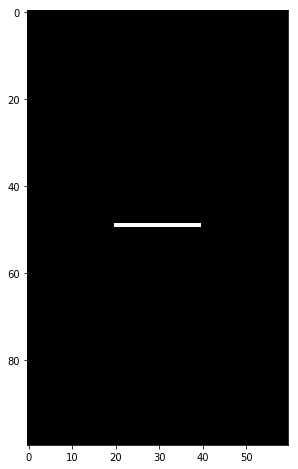

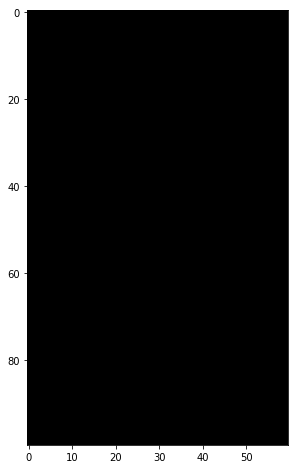

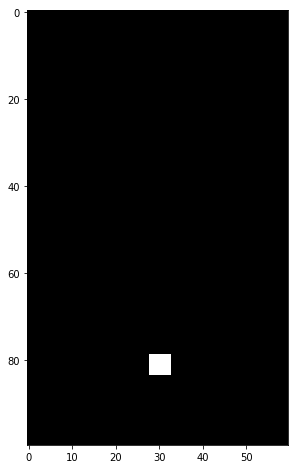

Display Favorability Topology!


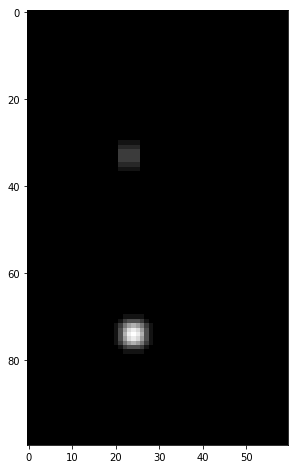

[(74, 24)]


In [58]:
for team, eye in zip(suntzu.teams, suntzu.eyes):
    print("SunTzu is strategist for Team {}.".format(team.name))
    print ("Agent {} ({} {}) is acting as eye for SunTzu.".format(eye.idx, eye.type, eye.role))

print ("Display the Big Picture!")
print (game_space.shape)
for i in range(7):
    plt.imshow(game_space[0,i,:,:])
    plt.show()

print ("Display Favorability Topology!")    
plt.imshow(topology)
plt.show()

print (goals)

# Train Team directed by Strategist

For now, a strategist can only direct 1 team with a drone agent, which acts as the "eye" for the strategist. The strategist access the game space through the complete obs space of the drone agent.

The code below run training on 2 teams of 5 Agents each. Both team Viking and Franks have Pacifist cultures so they are unagressive (do not fire their lasers). The Vikings have a drone leader and a strategist. The Franks do not.

Our strategist is able to take in the game space provided by its eye and output a goal in the form of a coordinate. 

The Team class must now take this goal ("move the team to this coordinate") and generate the mission reward such that its leader agent learns to move to that coordinate, thus taking many of its followers along in its target zone.


## A "Simple" DroneLeader

The DroneLeader_Simple is a 2-layer fully-connected NN that accepts the deltas between the drone leader's current coordinate vs the coordinate of max favorability as input, and outputs an action.

The policy works amazingly well at reaching the target coordinate. 

It is also general - meaning it will always reach the target coordinate even when we change the drone's starting coordinate or the target coordinate.

In [4]:
num_drone_actions = 12
num_goal_params = 2

drone_leader = DroneLeader_Simple(num_goal_params, num_drone_actions, 0)
print (drone_leader)

batch_size = 1
x = torch.randn(batch_size, 2)
output = drone_leader(x)
print(output)

DroneLeader_Simple(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU(inplace)
  )
  (action_head): Linear(in_features=32, out_features=12, bias=True)
)
tensor([[0.0913, 0.1244, 0.0976, 0.1187, 0.0684, 0.0527, 0.1807, 0.0377, 0.0504,
         0.0578, 0.0952, 0.0252]], grad_fn=<SoftmaxBackward>)


## Basic Training (1 Team with 1 Drone Leader)


In [6]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
torch.manual_seed(0)
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/strategist/'    # 1 team of 1 drone leader directed by a strategist

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.1, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300}
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 10
save_interval = 20

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  


def calc_deltas(goal, current):
    # Calculate delta between the current and the target coordinates
    target_x, target_y = goal
    current_x, current_y = current
    delta_x = target_x - current_x
    delta_y = target_y - current_y
    deltas = torch.Tensor([delta_x,delta_y])
    deltas = deltas.view(1, -1)
        
    # print(deltas)
    return deltas   
       

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    situation = 'pac_simple_droneleader'
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_Advanced(num_frames, num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_agent=0)   

    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode

    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    actions[i], log_probs[i] = select_action_strat(agents[i], agents_obs[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
            print('Drone Agent coordinate: {}'.format(deltas))

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)
    
    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
....

KeyboardInterrupt: 

## Advanced Training (1 Team with 1 Drone Leader + 10 Followers)

In [ ]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
torch.manual_seed(100)
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-11L/strategist/'    # 1 team of 1 drone leader + 10 crawler followers directed by a strategist

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':1.8, 'river_penalty':-1.0, 'target_reward':1.0, 'game_steps':300}
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 1000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 10
save_interval = 20

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3

# Initialize agents parameters
#   1 agents - 5 learning agents, 0 trained agent, 0 random agent
num_learners = 5
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  


def calc_deltas(goal, current):
    # Calculate delta between the current and the target coordinates
    target_x, target_y = goal
    current_x, current_y = current
    delta_x = (target_x - current_x)/60   # normalize
    delta_y = (target_y - current_y)/20    # normalize
    deltas = torch.Tensor([delta_x,delta_y])
    deltas = deltas.view(1, -1)
        
    # print(deltas)
    return deltas   
       

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    situation = 'pac_simple_droneleader_followers'
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (4,8)},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9)},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8)},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7)},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9)}
    ]

    """
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8)},
        {'id': 6, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (5,7)},
        {'id': 7, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (5,9)},
        {'id': 8, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (6,8)},
        {'id': 9, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (7,7)},
        {'id': 10, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (7,9)}

    ]
    """
        
    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_Advanced(num_frames, num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0],agents[1],agents[2],agents[3],agents[4]], \
                  #   agents[5],agents[6],agents[7],agents[8],agents[9],agents[10]],  \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = True, debug_agent=1)   

    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode

    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    actions[i], log_probs[i] =  select_action_strat(agents[i], agents_obs[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
            print('Drone Agent coordinate: {}'.format(deltas))

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)
    
    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
..........
Episode 10 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Max Norms =  ['18.55', '142.52', '204.46', '260.11', '155.72']
Drone Agent coordinate: tensor([[ 0.8667, -0.0500]])
..........
Episode 20 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0	Num agents cross

Max Norms =  ['25.91', '80.15', '120.28', '85.89', '76.65']
Drone Agent coordinate: tensor([[ 0.8667, -0.7500]])
..........
Episode 160 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.01658	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.02596	Num agents crossed: 0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Max Norms =  ['24.25', '118.32', '141.19', '77.97', '67.95']
Drone Agent coordinate: tensor([[ 0.8833, -0.2000]])
..........
Episode 170 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.05449	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running 

Max Norms =  ['34.01', '105.84', '100.97', '108.69', '92.85']
Drone Agent coordinate: tensor([[0.7667, 0.1000]])
..........
Episode 310 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.01486	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.07157	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.05004	Num agents crossed: 0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.01013	Num agents crossed: 0	Running mean: 0.0
Max Norms =  ['31.77', '105.59', '133.95', '94.80', '72.69']
Drone Agent coordinate: tensor([[ 0.7500, -0.0500]])
..........
Episode 320 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.01344	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: -0.1541	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward tota

..........
Episode 450 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.006235
Learner:1	Reward total:0	Running mean: 0.05573	Num agents crossed: 0	Running mean: 0.006235
Learner:2	Reward total:0	Running mean: -0.7613	Num agents crossed: 0	Running mean: 0.006235
Learner:3	Reward total:0	Running mean: 0.04473	Num agents crossed: 0	Running mean: 0.006235
Learner:4	Reward total:0	Running mean: 0.04972	Num agents crossed: 0	Running mean: 0.006235
Max Norms =  ['14.92', '109.27', '125.14', '84.62', '58.26']
Drone Agent coordinate: tensor([[0.6500, 0.0000]])
..........
Episode 460 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.01525
Learner:1	Reward total:0	Running mean: 0.0504	Num agents crossed: 0	Running mean: 0.01525
Learner:2	Reward total:0	Running mean: -0.7277	Num agents crossed: 0	Running mean: 0.01525
Learner:3	Reward total:0	Running mean: 0.04045	Num agents crossed: 0	Running mean: 0.01525
Learner:4

Max Norms =  ['26.77', '111.52', '57.38', '96.22', '90.17']
Drone Agent coordinate: tensor([[0.8000, 0.0500]])
..........
Episode 590 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.1047
Learner:1	Reward total:0	Running mean: -0.2356	Num agents crossed: 0	Running mean: 0.1047
Learner:2	Reward total:0	Running mean: -1.449	Num agents crossed: 0	Running mean: 0.1047
Learner:3	Reward total:0	Running mean: -0.5836	Num agents crossed: 0	Running mean: 0.1047
Learner:4	Reward total:0	Running mean: 0.09979	Num agents crossed: 0	Running mean: 0.1047
Max Norms =  ['39.78', '160.05', '82.32', '87.11', '90.35']
Drone Agent coordinate: tensor([[ 0.7167, -0.0500]])
..........
Episode 600 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.09467
Learner:1	Reward total:0	Running mean: -0.213	Num agents crossed: 0	Running mean: 0.09467
Learner:2	Reward total:0	Running mean: -1.31	Num agents crossed: 0	Running mean: 0.09467
L

Max Norms =  ['29.28', '87.16', '21.46', '78.16', '100.20']
Drone Agent coordinate: tensor([[ 0.5833, -0.1000]])
..........
Episode 730 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.0708
Learner:1	Reward total:0	Running mean: -0.07696	Num agents crossed: 1	Running mean: 0.0708
Learner:2	Reward total:0	Running mean: -0.3823	Num agents crossed: 1	Running mean: 0.0708
Learner:3	Reward total:9.0	Running mean: -0.7693	Num agents crossed: 1	Running mean: 0.0708
Learner:4	Reward total:0	Running mean: 0.2046	Num agents crossed: 1	Running mean: 0.0708
Max Norms =  ['17.04', '143.97', '1.40', '88.94', '95.61']
Drone Agent coordinate: tensor([[0.5333, 0.1000]])
..........
Episode 740 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.06403
Learner:1	Reward total:0	Running mean: -0.0696	Num agents crossed: 0	Running mean: 0.06403
Learner:2	Reward total:0	Running mean: -0.3458	Num agents crossed: 0	Running mean: 0.06

In [41]:
agents[0].rewards

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [12]:
env.close()